In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
# To UNSW-NB15's authors' credit, they do strip dst port from their DESIGNATED train / test sets, still sttl ruins their entire dataset
head = "/home/dhoogla/PhD/clean-ids-collection"
unsw_data = {    
    "unsw-nb15": f"{head}/unsw-nb15/dirty-with-metadata/UNSW-NB15.parquet",    
}

In [3]:
dataset = "unsw-nb15"
datapaths = [f"{unsw_data[dataset]}"]
datapaths

['/home/dhoogla/PhD/clean-ids-collection/unsw-nb15/dirty-with-metadata/UNSW-NB15.parquet']

In [4]:
df = pd.concat(objs=[pd.read_parquet(path) for path in datapaths], ignore_index=True, copy=False, sort=False, verify_integrity=False)

In [5]:
df.columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload',
       'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'label'],
      dtype='object')

In [6]:
df = df[['dsport', 'label']]
df['label'].value_counts()

False    1951069
True       84628
Name: label, dtype: int64

In [7]:
df['label'] = df['label'].astype(dtype='float32', copy=False)


In [8]:
col = df.columns[-1]
cols = df.columns[:-1]
vc = df[col].value_counts()
n = vc.iloc[-1]
m = vc.iloc[0]
initial_cut = df.loc[df[col] == vc.index[0]].sample(n=int(m-n), replace=False)
df = df.drop(index=initial_cut.index)

In [9]:
print(df.shape)
df['label'].value_counts()

(169256, 2)


0.0    84628
1.0    84628
Name: label, dtype: int64

In [10]:
gp = df.groupby('label')
with pd.option_context('display.max_rows', 50):
    print("BENIGN TOP PORTS")
    print(gp.get_group(0.0)['dsport'].value_counts())
    print("MALICIOUS TOP PORTS")
    print(gp.get_group(1.0)['dsport'].value_counts())

BENIGN TOP PORTS
53       16397
80        8461
6881      5284
5190      4990
111       3598
         ...  
62339        1
42096        1
7010         1
34007        1
28323        1
Name: dsport, Length: 23685, dtype: int64
MALICIOUS TOP PORTS
80       18898
53       16244
111       9508
179       5460
25        5124
         ...  
40932        1
51536        1
64763        1
42476        1
34913        1
Name: dsport, Length: 3182, dtype: int64


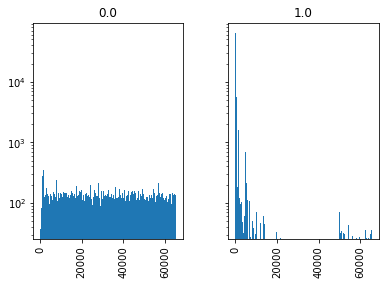

In [11]:
hist = df.hist(column='dsport', by='label', bins=128, log=True, sharey=True, sharex=True)

In [12]:
model = RF()
best_param_dict = {
        'bootstrap': True,
        'max_depth': 16,
        'max_features': 'sqrt',
        'min_impurity_decrease': 0.0,
        'min_samples_leaf': 2,
        'n_estimators': 10,
        'max_samples': 0.5,
        'criterion': 'entropy',
        'n_jobs': -1,
        }
model.set_params(**best_param_dict)

RandomForestClassifier(criterion='entropy', max_depth=16, max_samples=0.5,
                       min_samples_leaf=2, n_estimators=10, n_jobs=-1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['dsport'], df['label'], test_size=0.8, random_state=42)

In [14]:
model.fit(X=X_train.array.reshape(-1,1), y=y_train.array)

RandomForestClassifier(criterion='entropy', max_depth=16, max_samples=0.5,
                       min_samples_leaf=2, n_estimators=10, n_jobs=-1)

In [15]:
intra_outputs = model.predict(X=X_test.array.reshape(-1,1))
intra_acc = accuracy_score(y_true=y_test, y_pred=intra_outputs)
intra_rec = recall_score(y_true=y_test, y_pred=intra_outputs)
intra_pre = precision_score(y_true=y_test, y_pred=intra_outputs)
print(f"{dataset} => Destination Port")
print(f"Accuracy: {intra_acc:.3f}")
print(f"Recall: {intra_rec:.3f}")
print(f"Precision: {intra_pre:.3f}")


unsw-nb15 => Destination Port
Accuracy: 0.753
Recall: 0.908
Precision: 0.692
